# Introduction

In this project, I play the role of a Data Analyst for an electric vehicle (EV) company. The company wants to understand recent trends in the global EV market and forecast future market trends, in order to identify potential opportunities. I'll analyze historical EV sales and break them down by a few different factors including geography, mode, and powertrain. From there, I'll use a couple of different forecasting methods to see what the EV market may look like in the future if trends continue.

I'll primarily use historical EV sales data from the International Energy Agency (IEA). The IEA data is disaggregated by region (mostly country), mode (bus, car, truck, or van), powertrain (battery, plug-in hybrid, or fuel cell), and year (2010-2023). In order to analyze sales by continent, I'll use a separate table of countries and continents to map each country to its continent. Finally, for context on non-EV sales in select countries, I'll refer to data from the International Organization of Motor Vehicle Manufacturers (OICA). The data sources can be found below:

- IEA: https://www.iea.org/data-and-statistics/data-tools/global-ev-data-explorer
- Continents: https://www.kaggle.com/datasets/hserdaraltan/countries-by-continent/data
- OICA: https://www.oica.net/category/sales-statistics/

The project is organized in 4 main parts:

1. Data Preparation and Cleaning
2. SQL Set-Up
3. Historical EV Market Trend Analysis
4. Future Opportunity Projections

By the end of the project, I'll aim to answer these guiding questions:

- What regions or countries have been driving the growth of EV sales in recent years?
- Has the EV market been dominated by certain modes or powertrains?
- If trends continue, what opportunities might exist for an EV company to capture value in the next 10 years?

# 1. Data Preparation and Cleaning

I'll start by reading the IEA data into Python for exploration and cleaning. The data is actually broken down into 4 separate tables by mode, so there is one table each for buses, cars, trucks, and vans. Let's read each of them into a Pandas DataFrame and preview them.

In [367]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.chdir("/Users/ezrabaker/Documents/data_projects/ev_markets")

buses = pd.read_csv("IEA-EV-dataEV salesHistoricalBuses.csv")
cars = pd.read_csv("IEA-EV-dataEV salesHistoricalCars.csv")
trucks = pd.read_csv("IEA-EV-dataEV salesHistoricalTrucks.csv")
vans = pd.read_csv("IEA-EV-dataEV salesHistoricalVans.csv")

modes = {
    "Buses": buses,
    "Cars": cars,
    "Trucks": trucks,
    "Vans": vans
}

for name, mode in modes.items():
    print(f"Preview of {name}")
    print(mode.info())
    print(mode.head())
    print("\n")

Preview of Buses
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      1813 non-null   object 
 1   category    1813 non-null   object 
 2   parameter   1813 non-null   object 
 3   mode        1813 non-null   object 
 4   powertrain  1813 non-null   object 
 5   year        1813 non-null   int64  
 6   unit        1813 non-null   object 
 7   value       1813 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 113.4+ KB
None
    region    category       parameter   mode powertrain  year      unit  \
0  Belgium  Historical        EV stock  Buses        BEV  2010  Vehicles   
1  Belgium  Historical  EV stock share  Buses         EV  2010   percent   
2  Belgium  Historical  EV stock share  Buses         EV  2011   percent   
3  Belgium  Historical        EV stock  Buses        BEV  2011  Vehicles   
4  Belgium  Histor

Each table seems to follow a similar pattern. They each have 8 columns which appear to be in the same order. It seems there aren't any issues with missing data, which is great. Looking at each table, it seems there will be multiple lines for each "region" in each "year" based on the "parameter" column. For example, in the "cars" table, Australia has 4 entries for 2011: one each for EV sales, EV stock share, EV sales share, and EV stock. The corresponding units in the "unit" column also change based on the "parameter." I'll need to be mindful of this when writing SQL queries, especially when using aggregate functions and grouping clauses.

All columns are stored in Pandas as object types except for "year" and "value" which are numeric. Since the columns that are object types are actually strings, I'll manually change these to strings. I'll do this after I combine the tables into 1. 

I'd like to combine all 4 tables into 1 table before reading it into SQL. It helps that each table already has a "mode" column, so we won't have to add this before concatenating the tables together. But first, I'll check more closely to make sure all the tables in fact have the same columns in the same order.

In [369]:
for name, mode in modes.items():
    print(f"{name} columns:")
    print(mode.columns)

Buses columns:
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')
Cars columns:
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')
Trucks columns:
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')
Vans columns:
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')


It looks like all the tables have the same columns, so let's go ahead and concatenate them into 1 table. After concatenating, I'll check to make sure all the rows were successfully included.

In [371]:
evs = pd.concat([buses, cars, trucks, vans], ignore_index=True)

for name, mode in modes.items():
    print(f"Rows in {name}: {mode.shape[0]}")

print("\n")

print(f"Rows in all modes separately: {buses.shape[0] + cars.shape[0] + trucks.shape[0] + vans.shape[0]}")
print(f"Rows in concatenated DataFrame: {evs.shape[0]}")

Rows in Buses: 1813
Rows in Cars: 3798
Rows in Trucks: 1028
Rows in Vans: 1783


Rows in all modes separately: 8422
Rows in concatenated DataFrame: 8422


Based on the output above, we can see that all 8,422 rows from the 4 different tables were successfully concatenated into 1 table. Next, let's manually change the object types to strings, and then look more closely at the values in all the columns.

In [373]:
for column in ["region", "category", "parameter", "mode", "powertrain", "unit"]:
    evs[column] = evs[column].astype("string")

evs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8422 entries, 0 to 8421
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      8422 non-null   string 
 1   category    8422 non-null   string 
 2   parameter   8422 non-null   string 
 3   mode        8422 non-null   string 
 4   powertrain  8422 non-null   string 
 5   year        8422 non-null   int64  
 6   unit        8422 non-null   string 
 7   value       8422 non-null   float64
dtypes: float64(1), int64(1), string(6)
memory usage: 526.5 KB


In [374]:
for column in list(evs.columns):
    print(evs[column].value_counts())
    print("\n")

region
World                   578
Europe                  567
China                   484
EU27                    397
France                  334
Netherlands             330
Rest of the world       324
United Kingdom          320
Denmark                 295
Belgium                 288
Germany                 274
USA                     257
Sweden                  251
Norway                  243
Japan                   236
Spain                   222
Switzerland             221
Canada                  216
India                   212
Italy                   206
Korea                   193
Finland                 178
Poland                  174
New Zealand             172
Brazil                  171
Portugal                163
Israel                  132
Iceland                  96
Austria                  90
Australia                82
Chile                    77
Mexico                   70
South Africa             69
Turkiye                  64
Greece                   62
Hungary      

First, the "region" column appears to mostly have country names, although it does have a few aggregated entities such as "EU27" and "Rest of the world." I'll likely get rid of these extra aggregated entities since they don't account for all countries and I'll be doing my own aggregation by continent later, but I'll handle this a bit later. We've already spoken a bit about the "parameter" and "mode" columns. We can see that "powertrain" includes "BEV" (battery electric vehicle), "PHEV" (plug-in hybrid electric vehicle), and "FCEV" (fuel cell electric vehicle). Finally, as expected, "year" ranges from 2010 to 2023.

Next, since I'll be working primarily with EV sales, I want to check the values of the "EV sales" rows for any non-whole numbers (it doesn't make sense to sell a fraction of a vehicle).

In [376]:
pd.set_option('display.float_format', '{:.5f}'.format)
value_check = evs[(evs["parameter"] == "EV sales") & (evs["value"] % 1 != 0)]
print(value_check)

           region    category parameter   mode powertrain  year      unit  \
783        Israel  Historical  EV sales  Buses        BEV  2013  Vehicles   
1565          USA  Historical  EV sales  Buses        BEV  2012  Vehicles   
1572          USA  Historical  EV sales  Buses        BEV  2013  Vehicles   
4138  Netherlands  Historical  EV sales   Cars       FCEV  2014  Vehicles   

       value  
783  0.00100  
1565 6.50000  
1572 8.70000  
4138 2.20000  


It looks like there are just a few rows of EV sales with non-whole numbers. These might be errors in the original dataset. For my purposes, I'll just round these EV sales values to zero decimal places.

In [378]:
evs.loc[evs["parameter"] == "EV sales", "value"] = evs.loc[evs["parameter"] == "EV sales", "value"].round(0)
value_check_2 = evs[(evs["parameter"] == "EV sales") & (evs["value"] % 1 != 0)]
print(value_check_2)

Empty DataFrame
Columns: [region, category, parameter, mode, powertrain, year, unit, value]
Index: []


That worked. As we can see in the output above, when checking the second time (after rounding), there are no rows of EV sales where the value is a non-whole number. Next, as mentioned before, I'll work on the "region" column. Since I'm going to focus just on the country-specific rows in this table, I'll rename the "region" column to "country".

In [380]:
pd.set_option('display.float_format', '{:.0f}'.format)
evs = evs.rename(columns={"region": "country"})
print(evs.columns)

Index(['country', 'category', 'parameter', 'mode', 'powertrain', 'year',
       'unit', 'value'],
      dtype='object')


I'm curious to see how many different countries are in the dataset. Let's check the length of the list of unique country names in our table, keeping in mind that a few of these are aggregated entities but the majority are specific countries.

In [382]:
len(evs["country"].unique())

52

We have about 50 or so different countries in our IEA data. At some point I'll want to analyze by continent, but continent is not included in the IEA data, so we'll read in a separate table of countries and continents that we can use to join continents. This one comes from Kaggle, as mentioned in the Introduction.

In [384]:
continents = pd.read_csv("continents.csv")
continents.info()
continents.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   continent  196 non-null    object
 1   country    196 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


,continent,country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina


I want to check to make sure all the countries from the IEA data map cleanly to a country-continent pair in the continents table. There may be spelling errors or naming conventions that differ across the 2 tables. Let's check and see what differences there might be.

In [386]:
countries_in_evs = set(evs["country"])
countries_in_continents = set(continents["country"])
missing_countries = countries_in_evs - countries_in_continents

if missing_countries:
    print("Missing countries:", missing_countries)
else:
    print("All countries are present in the continent mapping.")

Missing countries: {'USA', 'Korea', 'Czech Republic', 'Turkiye', 'EU27', 'Europe', 'World', 'Rest of the world'}


As we can see from the output above, there are 8 country names from the IEA data that aren't found in the "continents" table. I'll change the names of the countries so they match. For the non-country entities, I'll go ahead and filter them out now.

In [388]:
evs = evs[~evs["country"].isin(["EU27", "World", "Rest of the world", "Europe"])]

evs.replace({
    "Czech Republic": "Czechia",
    "Korea": "South Korea",
    "USA": "United States"
}, inplace=True)

continents.replace({
    "Turkey": "Turkiye"
}, inplace=True)

countries_in_evs_2 = set(evs["country"])
countries_in_continents_2 = set(continents["country"])
missing_countries_2 = countries_in_evs_2 - countries_in_continents_2

if missing_countries_2:
    print("Missing countries:", missing_countries_2)
else:
    print("All countries are present in the continent mapping.")

All countries are present in the continent mapping.


Great! Now we've standardized the country names across the "evs" table and the "continents" table and filtered out the non-country entities. At this point, our data is pretty clean and ready to be read into SQL.

# 2. SQL Set-Up

Next, I'll read the 2 tables into PostgreSQL.

In [390]:
!pip install sqlalchemy psycopg2-binary

In [391]:
from sqlalchemy import create_engine

username = "postgres"
password = "password1"
host = "localhost"
port = "5432"
database = "ev_markets_db"

engine = create_engine(f"postgresql://{username}:{password}@{host}:{port}/{database}")

evs.to_sql("evs", con=engine, if_exists='replace', index=False)
continents.to_sql("continents", con=engine, if_exists='replace', index=False)

print("Data successfully loaded into ev_markets_db.")

Data successfully loaded into ev_markets_db.


As a quick check, I know there should be 48 unique values in the "country" column of "evs", since we removed 4 non-country entities. Let's query the SQL database to make sure the "evs" table has 48 unique countries.

In [393]:
check_query = """

SELECT COUNT(DISTINCT country) AS unique_region_count
  FROM evs;

"""

check_result = pd.read_sql(check_query, con=engine)
print(check_result)


   unique_region_count
0                   48


Looks good! Let's proceed to our analysis.

# 3. Historical EV Market Trend Analysis

To analyze the historical EV market trends, I'll break down EV sales by continent, country, mode, and powertrain. For each of these factors, I'll look both overall (total sales for the 14-year time period) as well as year-by-year to get a sense of growth patterns. Let's start with continents.

## Continents

       Continent  Total EVs Sold (2010-2023)  Percent Share
0           Asia                  25,035,359             59
1         Europe                  11,653,826             27
2  North America                   5,420,221             13
3        Oceania                     286,339              1
4  South America                     114,660              0
5         Africa                       3,801              0




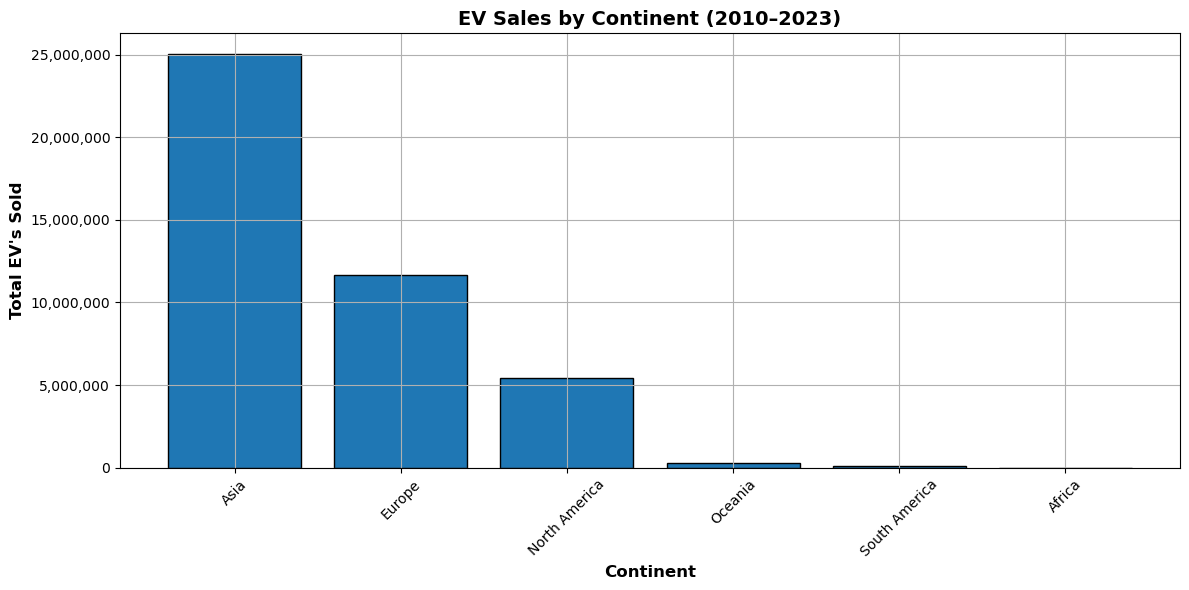

In [395]:
continents_total_query = """

SELECT c.continent AS "Continent",
       SUM(e.value) AS "Total EVs Sold (2010-2023)",
       ROUND(CAST(SUM(e.value) * 100.0 / SUM(SUM(e.value)) OVER () AS numeric), 1) AS "Percent Share"
  FROM evs AS e
  JOIN continents AS c
    ON e.country = c.country
 WHERE e.parameter = 'EV sales'
 GROUP BY c.continent
 ORDER BY SUM(e.value) DESC;

"""

continents_total_result = pd.read_sql(continents_total_query, con=engine)

# Set number formatting for Pandas DataFrames to display full numbers rather than scientific notation
pd.set_option('display.float_format', '{:,.0f}'.format)

print(continents_total_result)
print("\n")

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Set formatting to use for y-axes to show full numbers rather than scientific notation
formatter = FuncFormatter(lambda x, _: f"{int(x):,}")

fig, ax = plt.subplots(figsize=(12, 6))

plt.bar(continents_total_result["Continent"], continents_total_result["Total EVs Sold (2010-2023)"], edgecolor="black")
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Continent (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Total EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Continent", fontsize=12, weight="bold")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

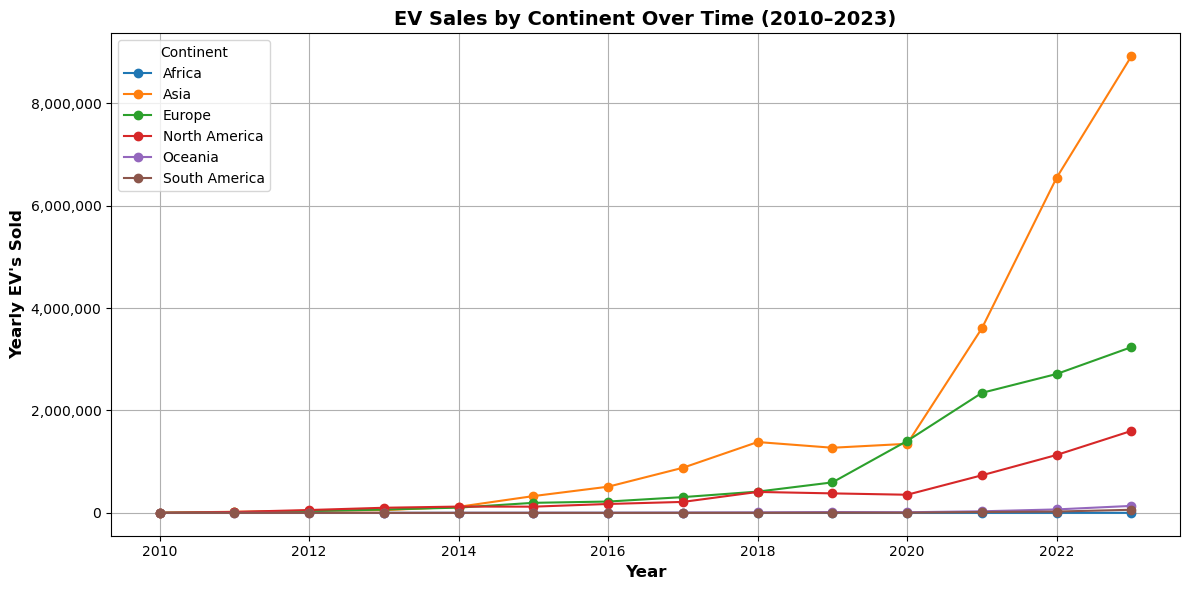

In [396]:
continents_yearly_query = """

SELECT c.continent AS "Continent",
       e.year AS "Year",
       SUM(e.value) AS "Total EVs Sold"
  FROM evs AS e
  JOIN continents AS c
    ON e.country = c.country
 WHERE e.parameter = 'EV sales'
 GROUP BY c.continent, e.year
 ORDER BY c.continent, e.year;

"""

continents_yearly_result = pd.read_sql(continents_yearly_query, con=engine)

continents_yearly_pivot = continents_yearly_result.pivot(index="Year", columns="Continent", values="Total EVs Sold")

ax = continents_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Continent Over Time (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Yearly EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Year", fontsize=12, weight="bold")
plt.grid(True)
plt.tight_layout()

We can see that the global EV market is dominated by sales in Asia, Europe, and North America. Asian sales accounted for 59% of the global total between 2010 and 2023. Europe came in second at 27%, followed by North America at 13%. The remaining 3 continents - Oceania, South America, and Africa - each accounted for just about 1% or less of the global total. When looking at year-by-year growth, we see a striking trend. EV sales across all continents were at relatively similar levels until about 2016 and then started to diverge. In particular, sales in Asia skyrocketed after 2020. Europe and North American markets also grew steadily since then, but the Asian market has been the clear leader in growth in the past few years. 

Let's dig into this more by seeing sales by country.

## Countries

          Country  Total EVs Sold (2010-2023)  Percent Share
0           China                  23,358,308             55
1   United States                   4,770,934             11
2         Germany                   3,012,826              7
3          France                   1,666,650              4
4  United Kingdom                   1,659,853              4
5          Norway                     879,813              2
6          Sweden                     706,166              2
7     Netherlands                     679,595              2
8     South Korea                     676,352              2
9           Japan                     627,730              2




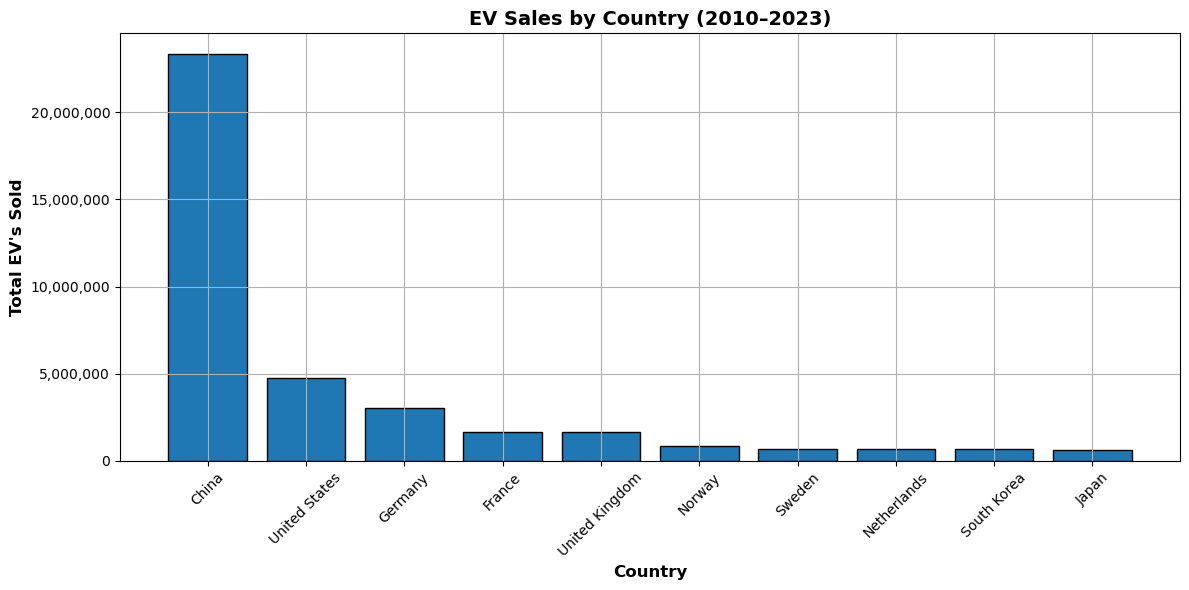

In [398]:
countries_total_query = """

SELECT country AS "Country",
       SUM(value) AS "Total EVs Sold (2010-2023)",
       ROUND(CAST(SUM(value) * 100.0 / SUM(SUM(value)) OVER () AS numeric), 1) AS "Percent Share"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY country
 ORDER BY SUM(value) DESC
 LIMIT 10;

"""

countries_total_result = pd.read_sql(countries_total_query, con=engine)
print(countries_total_result)
print("\n")

fig, ax = plt.subplots(figsize=(12, 6))

plt.bar(countries_total_result["Country"], countries_total_result["Total EVs Sold (2010-2023)"], edgecolor="black")
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Country (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Total EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Country", fontsize=12, weight="bold")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

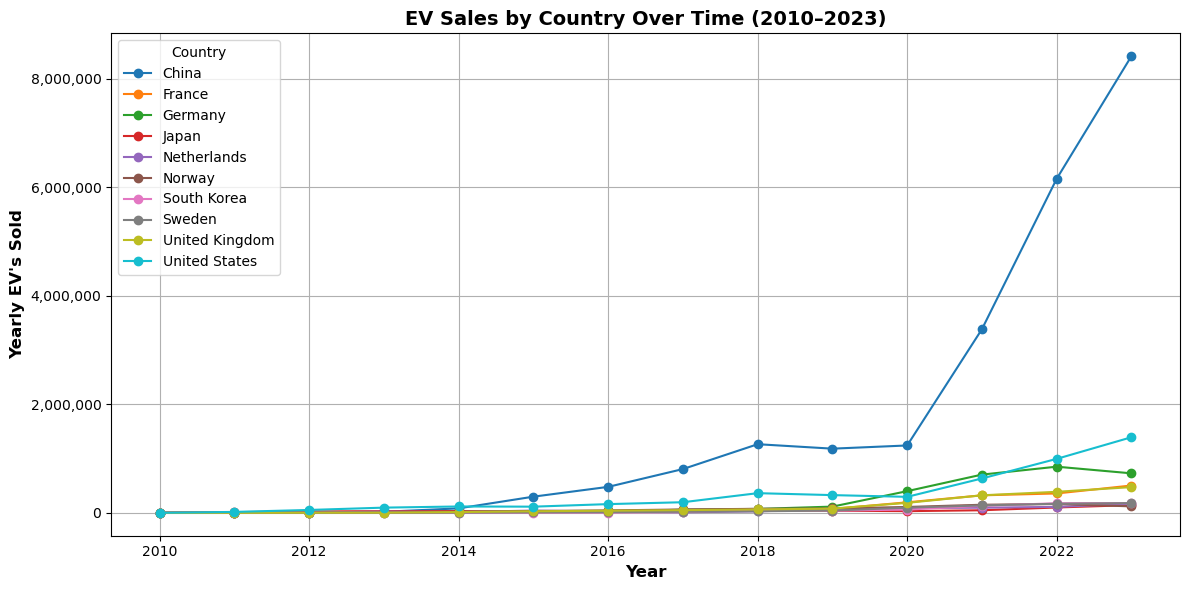

In [399]:
countries_yearly_query = """

SELECT country AS "Country",
       year AS "Year",
       SUM(value) AS "Total EVs Sold"
  FROM evs
 WHERE parameter = 'EV sales' AND country IN (
       SELECT country
         FROM evs
        WHERE parameter = 'EV sales'
        GROUP BY country
        ORDER BY SUM(value) DESC
        LIMIT 10
        )
 GROUP BY country, year
 ORDER BY country, year;

"""

countries_yearly_result = pd.read_sql(countries_yearly_query, con=engine)

countries_yearly_pivot = countries_yearly_result.pivot(index="Year", columns="Country", values="Total EVs Sold")

ax = countries_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Country Over Time (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Yearly EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Year", fontsize=12, weight="bold")
plt.grid(True)
plt.tight_layout()

Looking at EV sales by country, we can notice a couple important trends. First, the Asian and North American markets are primarily driven by one country in each continent: China and the United States, respectively. Meanwhile, the European market is a bit more diversified, with sales spread across Germany, France, the United Kingdom, and others. Second, because the Asian and North American markets are so dominated by one country, the country growth trends tend to mirror the trends by continent. China emerges as the clear leader in EV sales, with that lead widening dramatically since 2020. All in all, more than 23 million EV's were sold in China over the 14-year time period, accounting for 55% of the global total. Sales have grown steadily in the United States too, but nowhere near as quickly as in China.

Now that we've tackled geographic trends, let's look at a couple other factors, starting with modes (buses, cars, trucks, and vans).

## Modes

     Mode  Total EVs Sold (2010-2023)  Percent Share
0    Cars                  40,244,560             95
1    Vans                   1,305,968              3
2   Buses                     627,374              2
3  Trucks                     336,304              1




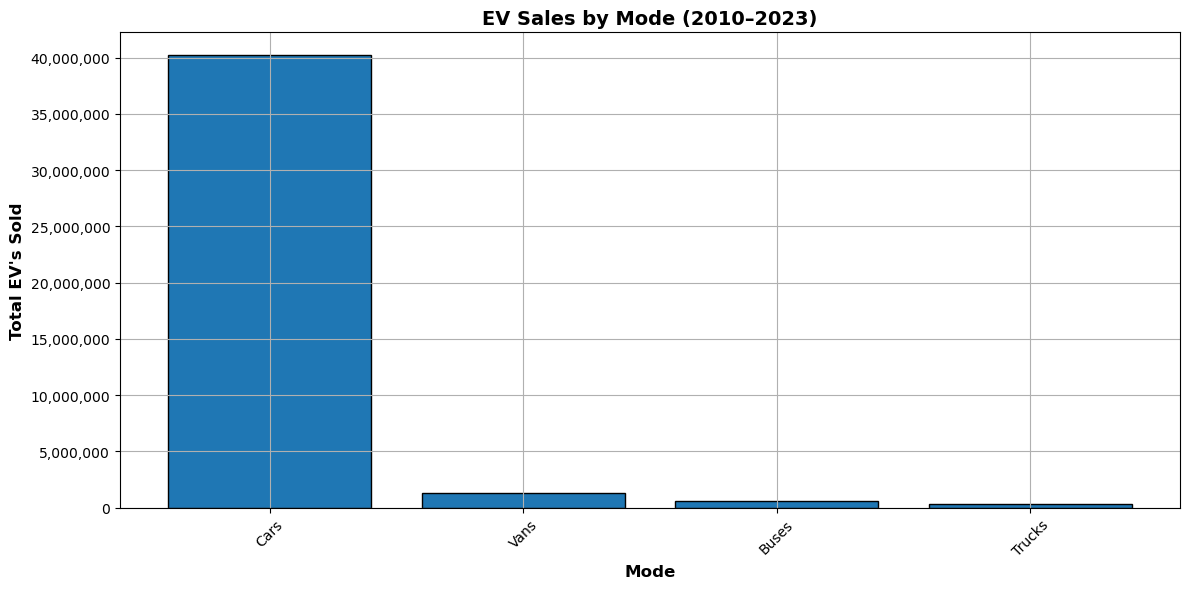

In [401]:
modes_total_query = """

SELECT mode AS "Mode",
       SUM(value) AS "Total EVs Sold (2010-2023)",
       ROUND(CAST(SUM(value) * 100.0 / SUM(SUM(value)) OVER () AS numeric), 1) AS "Percent Share"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY mode
 ORDER BY SUM(value) DESC;

"""

modes_total_result = pd.read_sql(modes_total_query, con=engine)
print(modes_total_result)
print("\n")

fig, ax = plt.subplots(figsize=(12, 6))

plt.bar(modes_total_result["Mode"], modes_total_result["Total EVs Sold (2010-2023)"], edgecolor="black")
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Mode (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Total EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Mode", fontsize=12, weight="bold")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

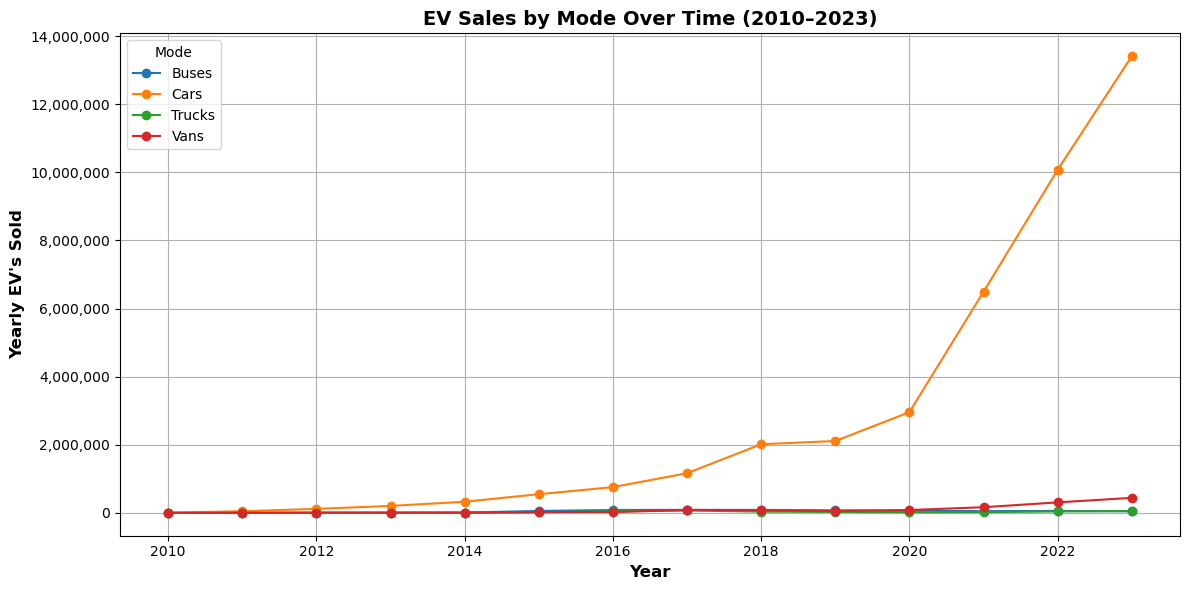

In [402]:
modes_yearly_query = """

SELECT mode AS "Mode",
       year AS "Year",
       SUM(value) AS "Total EVs Sold"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY mode, year
 ORDER BY mode, year

"""

modes_yearly_result = pd.read_sql(modes_yearly_query, con=engine)

modes_yearly_pivot = modes_yearly_result.pivot(index="Year", columns="Mode", values="Total EVs Sold")

ax = modes_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Mode Over Time (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Yearly EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Year", fontsize=12, weight="bold")
plt.grid(True)
plt.tight_layout()

In terms of mode, the trend in the IEA data is pretty straightforward. The vast majority of the growth in EV sales in recent years is due to cars, while the other modes (buses, trucks, and vans) have not moved much. Over the 14-year time period, cars accounted for 95% of global EV sales. Next, let's look at powertrains.

## Powertrains

  Powertrain  Total EVs Sold (2010-2023)  Percent Share
0        BEV                  30,110,768             71
1       PHEV                  12,314,143             29
2       FCEV                      89,295              0




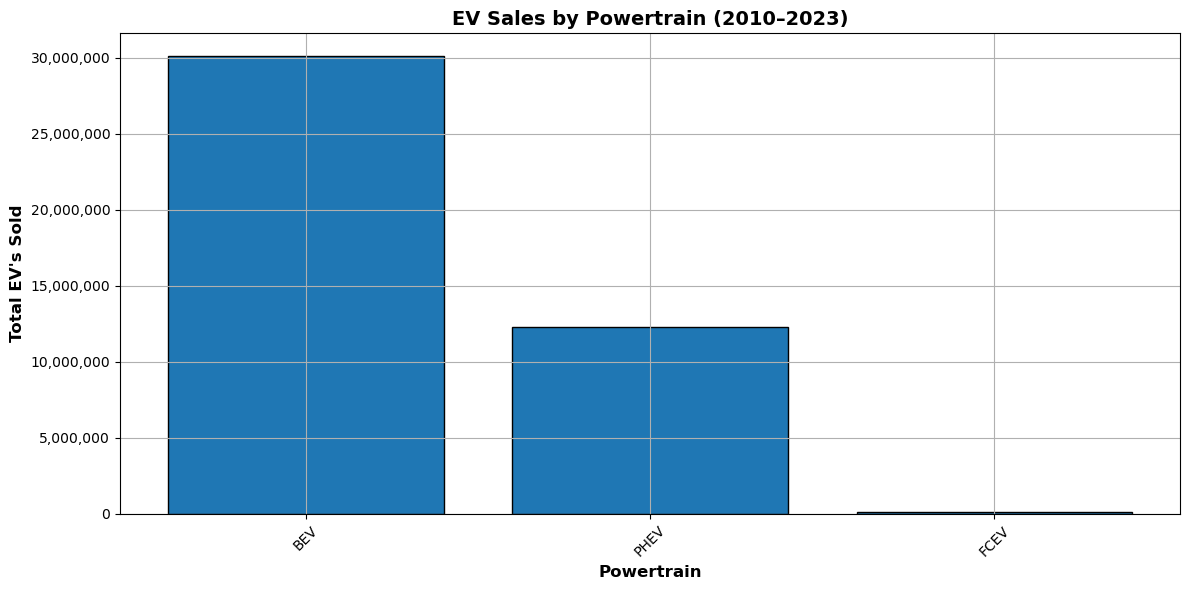

In [404]:
powertrains_total_query = """

SELECT powertrain AS "Powertrain",
       SUM(value) AS "Total EVs Sold (2010-2023)",
       ROUND(CAST(SUM(value) * 100.0 / SUM(SUM(value)) OVER () AS numeric), 1) AS "Percent Share"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY powertrain
 ORDER BY SUM(value) DESC;

"""

powertrains_total_result = pd.read_sql(powertrains_total_query, con=engine)
print(powertrains_total_result)
print("\n")

fig, ax = plt.subplots(figsize=(12, 6))

plt.bar(powertrains_total_result["Powertrain"], powertrains_total_result["Total EVs Sold (2010-2023)"], edgecolor="black")
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Powertrain (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Total EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Powertrain", fontsize=12, weight="bold")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

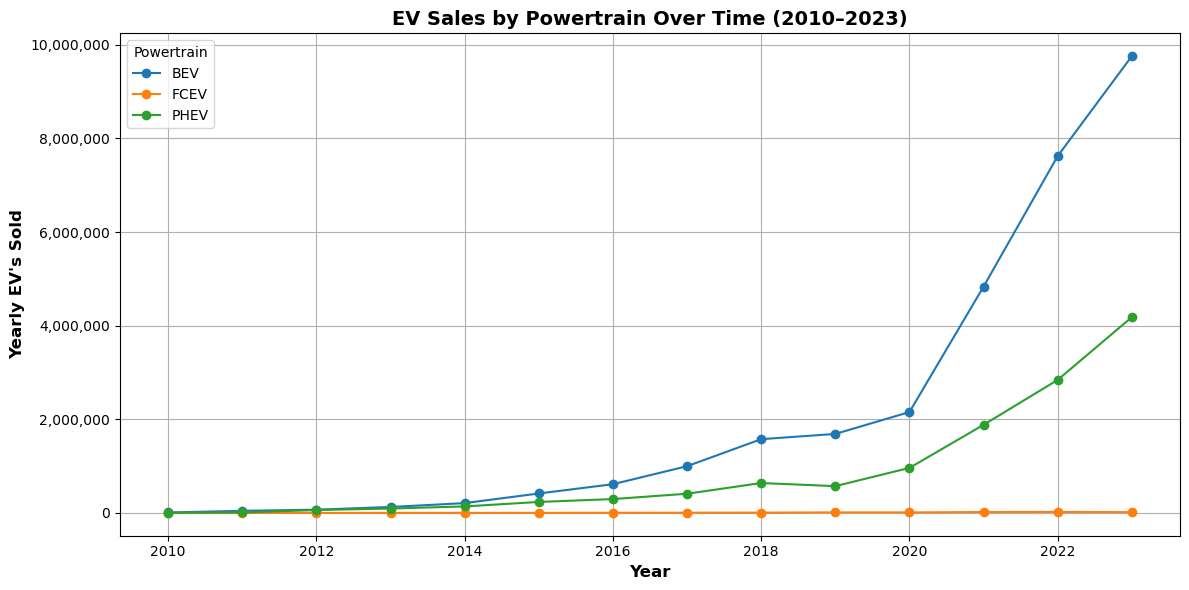

In [405]:
powertrains_yearly_query = """

SELECT powertrain AS "Powertrain",
       year AS "Year",
       SUM(value) AS "Total EVs Sold"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY powertrain, year
 ORDER BY powertrain, year

"""

powertrains_yearly_result = pd.read_sql(powertrains_yearly_query, con=engine)

powertrains_yearly_pivot = powertrains_yearly_result.pivot(index="Year", columns="Powertrain", values="Total EVs Sold")

ax = powertrains_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Powertrain Over Time (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Yearly EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Year", fontsize=12, weight="bold")
plt.grid(True)
plt.tight_layout()

Compared to modes, the distribution of powertrains is a bit more balanced. Battery electric vehicles (BEV's) accounted for 71% of global EV sales over the time period, with plug-in hybrids (PHEV's) making up 29%. Fuel cell electric vehicles (FCEV's) accounted for less than 1%. In terms of growth patterns, BEV's and PHEV's appear to have roughly similar trajectories. Both have grown steadily since about 2016 and taken off more since 2020.

As one final check, it would be interesting to see if the twin growth of BEV's and PHEV's is present in China, as the leading country in the EV market, or if Chinese EV sales tend to favor one powertrain or the other. Let's check this out.

## Powertrains in China

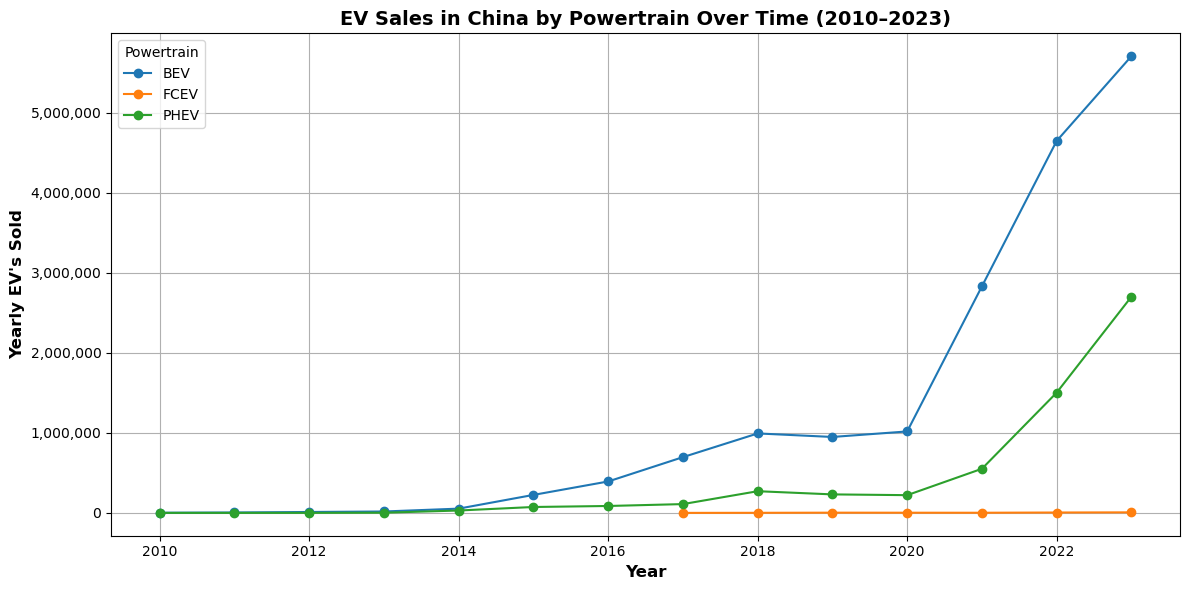

In [407]:
powertrains_china_yearly_query = """

SELECT powertrain AS "Powertrain",
       year AS "Year",
       SUM(value) AS "Total EVs Sold"
  FROM evs
 WHERE parameter = 'EV sales' AND country = 'China'
 GROUP BY powertrain, year
 ORDER BY powertrain, year

"""

powertrains_china_yearly_result = pd.read_sql(powertrains_china_yearly_query, con=engine)

powertrains_china_yearly_pivot = powertrains_china_yearly_result.pivot(index="Year", columns="Powertrain", values="Total EVs Sold")

ax = powertrains_china_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales in China by Powertrain Over Time (2010–2023)", fontsize=14, weight="bold")
plt.ylabel("Yearly EV's Sold", fontsize=12, weight="bold")
plt.xlabel("Year", fontsize=12, weight="bold")
plt.grid(True)
plt.tight_layout()

Based on the graph above, at first glance it looks like powertrain growth trends in China seem to mirror the rest of the world. The market is mostly driven by BEV's with a smaller, but still important, role for PHEV's.

## Summary of Historical Market Trends

At this stage of the project, we can answer a couple of the guiding questions we laid out in the Introduction:

- What regions or countries have been driving the growth of EV sales in recent years?
- Has the EV market been dominated by certain modes or powertrains?

EV sales have increased tremendously since 2020. This growth was driven primarily by China. There has been some growth in the United States and Europe, but China is by far outpacing the rest of the world. Furthermore, most of the growth has been in BEV's, but PHEV's have shown solid growth too. Finally, global EV sales are dominated by cars rather than buses, trucks, or vans.

## Snapshot of EV's as a Share of Total Car Sales

At this point, it's helpful to contextualize the growth of EV sales in relation to overall automobile markets. For this, we can pull in some data on total car sales from OICA, which is available for 2019-2024. We'll focus on the top 5 EV countries: China, the United States, Germany, France, and the United Kingdom.


In [409]:
all_cars = pd.read_csv("total_car_sales.csv")
all_cars.to_sql("all_cars", con=engine, if_exists='replace', index=False)

cars_share_query = """
    
    WITH total_sales AS (
        SELECT *
          FROM all_cars
         WHERE year != 2024
         ),
         
    ev_sales AS (
        SELECT country, year, 
               SUM(value) AS ev_sales
          FROM evs
         WHERE parameter = 'EV sales' AND country IN ('China', 'United States', 'Germany', 'France', 'United Kingdom')
         GROUP BY country, year
         )

    SELECT e.country, e.year, e.ev_sales,
           t.total_car_sales - e.ev_sales AS non_ev_sales
      FROM ev_sales AS e
      JOIN total_sales AS t 
        ON e.country = t.country AND e.year = t.year
     ORDER BY e.country, e.year;
     """

cars_share_df = pd.read_sql(cars_share_query, con=engine)
print(cars_share_df)

           country  year  ev_sales  non_ev_sales
0            China  2019 1,183,458    24,613,473
1            China  2020 1,242,328    24,068,741
2            China  2021 3,384,662    22,929,601
3            China  2022 6,155,910    20,707,835
4            China  2023 8,415,640    21,678,058
5           France  2019    72,465     2,683,263
6           France  2020   194,605     1,905,425
7           France  2021   323,494     1,818,790
8           France  2022   357,902     1,568,652
9           France  2023   504,493     1,704,008
10         Germany  2019   115,710     3,901,349
11         Germany  2020   400,468     2,866,291
12         Germany  2021   705,423     2,267,896
13         Germany  2022   851,376     2,112,372
14         Germany  2023   728,768     2,475,530
15  United Kingdom  2019    78,918     2,657,641
16  United Kingdom  2020   184,651     1,780,009
17  United Kingdom  2021   323,907     1,725,098
18  United Kingdom  2022   388,432     1,555,140
19  United Kingdom  

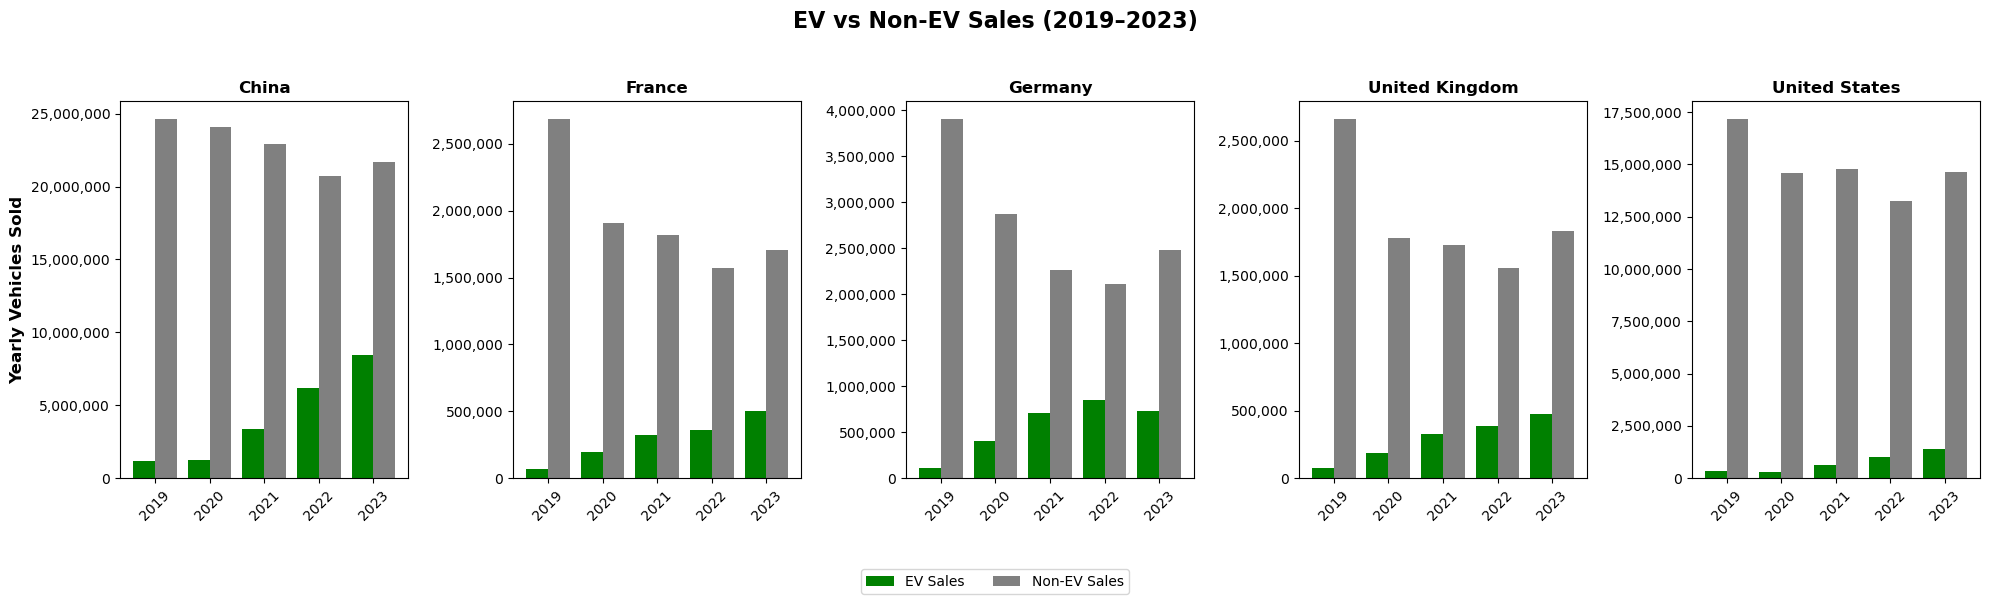

In [410]:
countries = cars_share_df["country"].unique()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=False)
fig.suptitle("EV vs Non-EV Sales (2019–2023)", fontsize=16, weight="bold")

for i, country in enumerate(countries):
    ax = axes[i]
    country_data = cars_share_df[cars_share_df["country"] == country]

    ax.bar(country_data["year"] - 0.2, country_data["ev_sales"], width=0.4, label="EV Sales", color="green")
    ax.bar(country_data["year"] + 0.2, country_data["non_ev_sales"], width=0.4, label="Non-EV Sales", color="gray")

    ax.yaxis.set_major_formatter(formatter)
    ax.set_title(country, fontsize=12, weight="bold")
    ax.set_xticks(country_data["year"])
    ax.set_xticklabels(country_data["year"], rotation=45)
    if i == 0:
        ax.set_ylabel("Yearly Vehicles Sold", fontsize=12, weight="bold")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

Based on the graphs above, we see similar trends in terms of EV market share across the top 5 countries. In general, the number of non-EV vehicles sold tended downward over 2020-2022 and then rebounded slightly in 2023. Meanwhile, EV's steadily climbed and made gains on non-EV's. This is especially true in China where the number of EV's came close to half of the number of non-EV's sold.

# 4. Future Opportunity Projections

In this section, we'll attempt to answer the last of the guiding questions:

- If trends continue, what opportunities might exist for an EV company to capture value in the next 10 years?

The major trends we identified in the historical analysis were related to sales volume by country and market share by powertrain. Let's attempt to forecast what the global EV market may look like in the next 10 years, if these trends were to continue.

## Projected EV Sales Volume by Country

Projected 2033 EV Sales in China: 20,185,077
Projected 2033 EV Sales in United States: 3,191,392
Projected 2033 EV Sales in Germany: 1,667,796
Projected 2033 EV Sales in France: 1,148,179
Projected 2033 EV Sales in United Kingdom: 1,083,457


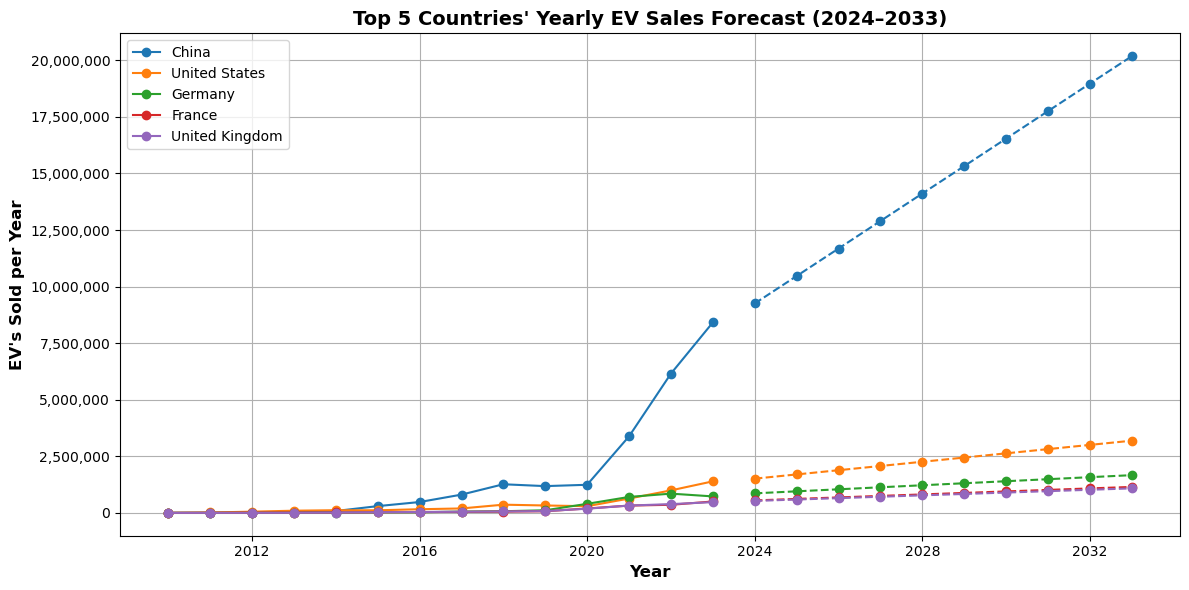

In [413]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools

plt.figure(figsize=(12, 6))

color_cycle = plt.cm.tab10.colors
color_iterator = itertools.cycle(color_cycle)
country_colors = {}

top_5_countries = countries_total_result["Country"].head(5).to_list()

for country in top_5_countries:
    
    if country not in country_colors:
        country_colors[country] = next(color_iterator)
    
    color = country_colors[country]

    country_sales_query = f"""
    
    SELECT country AS "Country",
           year AS "Year",
           SUM(value) AS "Total EVs Sold"
      FROM evs
     WHERE parameter = 'EV sales' AND country = '{country}'
     GROUP BY country, year
     ORDER BY year;
    
    """

    country_sales = pd.read_sql(country_sales_query, con=engine)

    country_sales["Year"] = pd.to_datetime(country_sales["Year"], format="%Y")
    country_sales.set_index("Year", inplace=True)
    country_sales.index.freq = 'YS' 

    init_level = country_sales["Total EVs Sold"].iloc[0]
    init_trend = (country_sales["Total EVs Sold"].iloc[-1] - country_sales["Total EVs Sold"].iloc[0]) / len(country_sales)

    model = ExponentialSmoothing(
        country_sales["Total EVs Sold"],
        trend="add",
        seasonal=None,
        initialization_method="known",
        initial_level=init_level,
        initial_trend=init_trend
    ).fit(
        optimized=False,
        smoothing_level=0.8,
        smoothing_trend=0.2
    )

    forecast = model.forecast(10)
    forecast_years = pd.date_range(start="2024", periods=10, freq="YS")
    forecast_series = pd.Series(forecast.values, index=forecast_years)
    print(f"Projected 2033 EV Sales in {country}: {forecast_series.iloc[-1]:,.0f}")

    plt.plot(country_sales.index, country_sales["Total EVs Sold"], label=f"{country}", marker='o', color=color)
    plt.plot(forecast_series.index, forecast_series, marker='o', linestyle='--', color=color)

plt.title("Top 5 Countries' Yearly EV Sales Forecast (2024–2033)", fontsize=14, weight="bold")
plt.xlabel("Year", fontsize=12, weight="bold")
plt.ylabel("EV's Sold per Year", fontsize=12, weight="bold")
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save this for use as a hero visual
plt.savefig("ev_forecasts_hero.png", dpi=300)

plt.show()

In the output above, I've used exponential smoothing to forecast future sales volume trends for each of the top 5 countries. Based on this forecast, EV sales would reach more than 20 million per year in China by 2033. The United States would come in second with over 3 million EV's sold per year, while Germany, France, and the United Kingdom would each reach between 1 and 2 million. In this scenario, the gap between China and the other countries continues to widen, suggesting the most future opportunities would exist in the Chinese market. However, even though markets would be comparatively much smaller, sizeable markets would still continue to develop in the United States and Europe. 

Before moving on, I'll test the fit of the forecast models to get a sense of how likely the forecasts are to be accurate. For each of the top 5 countries, I'll split the data into a training set (2010-2020) and a test set (2021-2023) and then assess how closely the forecast aligns with the test set using root mean square error (RMSE).

In [415]:
from sklearn.metrics import mean_squared_error

rmse_dict = {}

for country in top_5_countries:
    rmse_query = f"""
        SELECT year, 
               SUM(value) as total_ev_sales
          FROM evs
         WHERE country = '{country}' AND parameter = 'EV sales'
         GROUP BY country, year
         ORDER BY year;
         """

    rmse_df = pd.read_sql(rmse_query, con=engine)
    rmse_df["year"] = pd.to_datetime(rmse_df["year"], format="%Y")
    rmse_df.set_index("year", inplace=True)
    rmse_df.index.freq = "YS"

    train = rmse_df.loc["2010":"2020"]
    test = rmse_df.loc["2021":"2023"]

    init_level = train["total_ev_sales"].iloc[0]
    init_trend = (train["total_ev_sales"].iloc[-1] - train["total_ev_sales"].iloc[0]) / len(train)

    model = ExponentialSmoothing(
        train["total_ev_sales"],
        trend="add",
        seasonal=None,
        initialization_method="known",
        initial_level=init_level,
        initial_trend=init_trend
    ).fit(optimized=False, smoothing_level=0.8, smoothing_trend=0.2)

    forecast = model.forecast(3)
    forecast.index = pd.date_range(start="2021", periods=3, freq="YS")

    rmse = np.sqrt(mean_squared_error(test["total_ev_sales"], forecast))
    rmse_dict[country] = rmse

rmse_table = pd.DataFrame.from_dict(rmse_dict, orient='index', columns=["RMSE (2021–2023)"])
rmse_table.index.name = "Country"
rmse_table.reset_index(inplace=True)
print(rmse_table)

          Country  RMSE (2021–2023)
0           China         4,836,642
1   United States           702,528
2         Germany           299,967
3          France           176,364
4  United Kingdom           181,826


The results of the RMSE analysis vary by country, indicating the model fits better for some countries than others. For example, RMSE is very high for China (the forecast is off by about 4.8 million vehicles each year) and somewhat high for the United States (about 700,000 vehicles). Meanwhile, RMSE is much lower for Germany, France, and the United Kingdom. This makes sense because, as we can see in the previous graph, actual EV sales increased dramatically in China after 2020, creating a substantial divergence between the training set (2010–2020) and the test set (2021–2023). By contrast, actual EV sales trends were much more moderate in the other four countries.

The RMSE analysis highlights just how sharply China's EV market has accelerated in recent years—and suggests that the 10-year projection for China is largely driven by an assumption that this rapid growth will continue at a similar pace. It also underscores the importance of regularly updating forecasting models as market behavior changes over time.

## Projected Powertrain Market Share

In [418]:
powertrain_sales_query = """

SELECT year AS "Year",
       powertrain AS "Powertrain",
       SUM(value) AS "Sales"
  FROM evs
 WHERE parameter = 'EV sales' AND powertrain IN ('BEV', 'PHEV')
 GROUP BY year, powertrain
 ORDER BY year, powertrain;

"""

powertrain_sales = pd.read_sql(powertrain_sales_query, con=engine)

powertrain_sales_pivot = powertrain_sales.pivot(index="Year", columns="Powertrain", values="Sales")

powertrain_sales_pivot["BEV Share (%)"] = powertrain_sales_pivot["BEV"] * 100 / (powertrain_sales_pivot["BEV"] + powertrain_sales_pivot["PHEV"])
powertrain_sales_pivot["PHEV Share (%)"] = powertrain_sales_pivot["PHEV"] * 100 / (powertrain_sales_pivot["BEV"] + powertrain_sales_pivot["PHEV"])

from sklearn.linear_model import LinearRegression

columns_for_reg = {
    "BEV": powertrain_sales_pivot["BEV Share (%)"],
    "PHEV": powertrain_sales_pivot["PHEV Share (%)"]
}

for name, column in columns_for_reg.items():
    X = powertrain_sales_pivot.index.values.reshape(-1, 1)
    y = column
    reg = LinearRegression().fit(X, y)
    print(f"Regression Coefficient for {name} Share: {reg.coef_}")
    print(f"Projected Market Share (%) for {name}s in 2033: {reg.predict([[2033]])}")
    print("\n")

Regression Coefficient for BEV Share: [-0.18461623]
Projected Market Share (%) for BEVs in 2033: [66.99586012]


Regression Coefficient for PHEV Share: [0.18461623]
Projected Market Share (%) for PHEVs in 2033: [33.00413988]




Here, I've used linear regression on market share percentage to forecast changes in market share by powertrain over the next 10 years. Note, since FCEV's played such a small role in EV sales historically, I just considered the market share between BEV's and PHEV's. Based on the output above, the relative market share between BEV's and PHEV's is expected to remain fairly stable over the next 10 years, with PHEV's perhaps making modest gains on BEV's. The regression coefficients suggest BEV market share decreases by 0.18 percentage points each year, while PHEV market share increases by that same margin. By 2033, the global EV market would be about two-thirds BEV's and one-third PHEV's. The fact that these changes are so modest suggests the EV market may have reached a point of relative maturity in terms of powertrains.

In [420]:
engine.dispose()

# Conclusion

In this project, I played the role of a Data Analyst for an EV company seeking to understand global EV market trends and identify future opportunities. I analyzed historical EV sales by geography, mode, and powertrain, and used forecasting methods to see what the EV market may look like in the future. I found that the global EV market has been driven primarily by sales growth in China with slow and steady growth as well in the United States and Europe. The gap between China and the rest of the world looks set to expand over the next 10 years if current trends continue. Cars account for the vast majority of EV sales, instead of other vehicle modes, with about two-thirds of vehicles being battery electric (BEV) and one-third plug-in hybrid (PHEV).